In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pyEDM
import pyEDM as edm

In [222]:
# '''
# Binary prediction skill (“bloom” or “no bloom”) is
# evaluated by how well bloom predictions (5% largest predicted values)
# correspond to bloom observations (5%largest observed values)
# Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
# Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
# '''
# def bloom_binary_prediction(obs,pred,threshold=8.03199999999999):
#     #obs_bloom_95 = np.percentile(obs, 95) #incorrect
#     #pred_bloom_95 = np.percentile(pred, 95) #incorrect
#     obs_blooms = obs > threshold
#     pred_blooms = pred > threshold
#     Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
#     True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
#     False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
#     True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
#     False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
#     return [Accuracy, True_pos, False_pos, True_neg, False_neg]

In [223]:
def bloom_binary_prediction(observations, predictions, threshold):
    
    obs_blooms = observations > threshold  
    pred_blooms = predictions > threshold  

    true_pos = (obs_blooms & pred_blooms).sum()
    false_neg = (obs_blooms & (~pred_blooms)).sum()

    obs_bloom_sum = obs_blooms.sum()  # Store sum to check if it's zero

    true_pos_rate = true_pos / obs_bloom_sum if obs_bloom_sum > 0 else 0
    false_neg_rate = false_neg / obs_bloom_sum if obs_bloom_sum > 0 else 0

    # False positives: predicted bloom but no observed bloom
    false_pos = (~obs_blooms & pred_blooms).sum()
    false_pos_rate = false_pos / (~obs_blooms).sum() if (~obs_blooms).sum() > 0 else 0

    return true_pos_rate, false_neg_rate, false_pos_rate

In [234]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions (5% largest predicted values)
correspond to bloom observations (5%largest observed values)
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def bloom_binary_prediction(obs,pred,threshold=8.03199999999999):
    obs_bloom_95 = np.percentile(obs, 95) #incorrect
    pred_bloom_95 = np.percentile(pred, 95) #incorrect
    obs_blooms = obs > obs_bloom_95
    pred_blooms = pred > pred_bloom_95
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]


In [235]:
# for t in [2, 3, 4, 5, 6]:  # Adjust based on observations.describe()
#     cur_bloom = bloom_binary_prediction(observations, predictions, t)
#     print(f"Threshold {t}: TP Rate = {cur_bloom[0]}, FP Rate = {cur_bloom[2]}")

In [236]:
paper_data = pd.read_csv('Data/cleaned_data.csv')
paper_data = paper_data.set_index('time (UTC)')
paper_data['Time'] = paper_data.index.astype(int)
print(paper_data)

            Avg_Chloro  Nitrate  Phosphate  Silicate  Nitrite  SURF_TEMP_C  \
time (UTC)                                                                   
0.0               1.82     0.43       0.24       5.6     0.03         20.3   
7.0               2.71     0.83       0.37       5.1     0.04         17.8   
13.0              0.99     0.45       0.24       3.5     0.00         22.2   
20.0              1.23     0.34       0.17       4.2     0.00         19.8   
28.0              2.41     0.29       0.12       3.8     0.00         22.5   
...                ...      ...        ...       ...      ...          ...   
5789.0            3.22     0.85       0.30       6.2     0.00         17.4   
5796.0            3.39     0.45       0.25       4.9     0.00         17.9   
5803.0            7.82     0.00       0.17       5.2     0.00         18.3   
5811.0           17.30     0.00       0.20       9.4     0.00         18.0   
5817.0           16.71     0.00       0.10       7.5     0.00   

In [237]:
# df = paper_data
# df['Log_Avg_Chloro'] = np.log1p(df['Avg_Chloro'])
# df

In [238]:
# Define the features to use
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler


features = ['Nitrate', 'Phosphate', 'Silicate', 'Nitrite', 
            'AVG_TEMP_C', 'AVG_SAL_PSU', 'AVG_DENS_kgm3', 'Avg_Chloro']

# Choose transformation
transformation = "log" 

if transformation == "log":
    paper_data[features] = np.log1p(paper_data[features])  # Log transformation
elif transformation == "standardize":
    scaler = StandardScaler()
    paper_data[features] = scaler.fit_transform(paper_data[features])  # Standardization
elif transformation == "minmax":
    scaler = MinMaxScaler()
    paper_data[features] = scaler.fit_transform(paper_data[features])  # Min-Max Scaling
elif transformation == "robust":
    scaler = RobustScaler()
    paper_data[features] = scaler.fit_transform(paper_data[features])  # Robust Scaling


# Create time series dataframe
time_series = paper_data[['Time'] + features]


In [239]:
# Embed the data
embedded = edm.Embed(
    dataFrame=time_series,
    columns=" ".join(features),
    E=3,  
    tau=-1
)


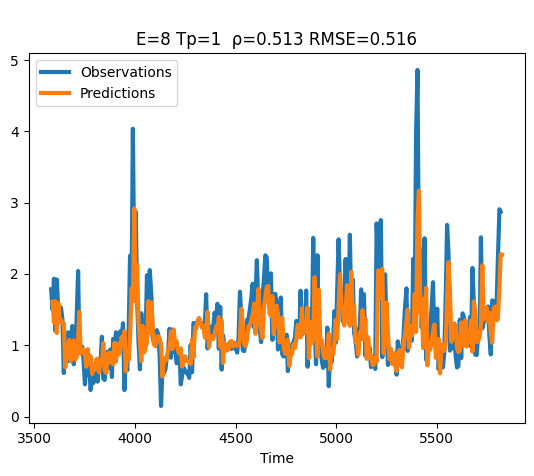

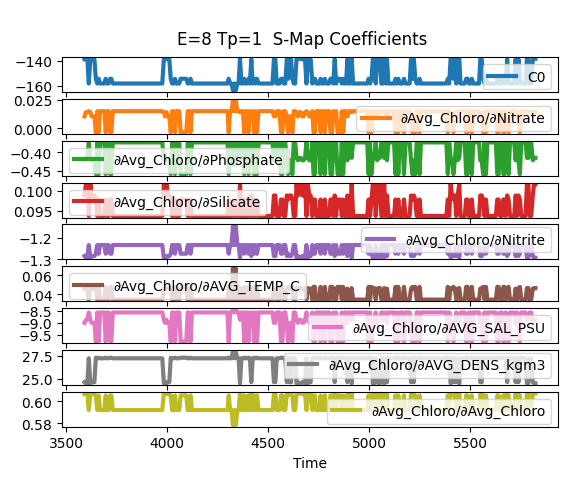

In [240]:
result = edm.SMap(
    dataFrame=time_series,
    columns=" ".join(features),
    target="Avg_Chloro",
    lib="1 512",
    pred="513 832",
    E=8,
    theta=0,
    tau=-3,
    showPlot=True,
    embedded=True,
    ignoreNan=True
)

In [241]:
# Evaluate binary bloom prediction
bloom_results = bloom_binary_prediction(
    result["predictions"]["Observations"].iloc[1:-1],
    result["predictions"]["Predictions"].iloc[1:-1], np.log(8.03199999999999)
)

print(f"Bloom Prediction Results ({transformation}):", bloom_results)

Bloom Prediction Results (log): [np.float64(0.9184952978056427), np.float64(0.1875), np.float64(0.0429042904290429), np.float64(0.9570957095709571), np.float64(0.8125)]


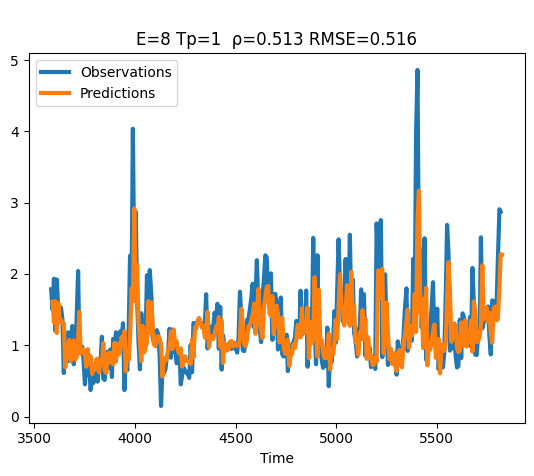

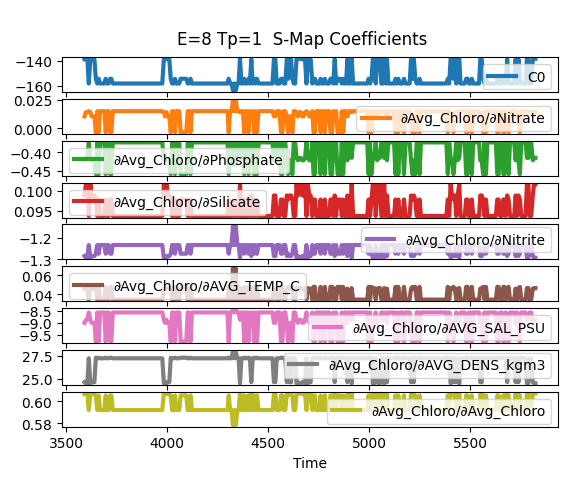

Theta: 0
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.0429042904290429, TP Rate: 0.1875


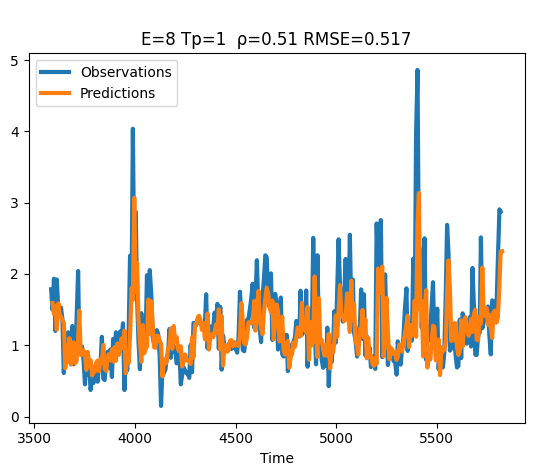

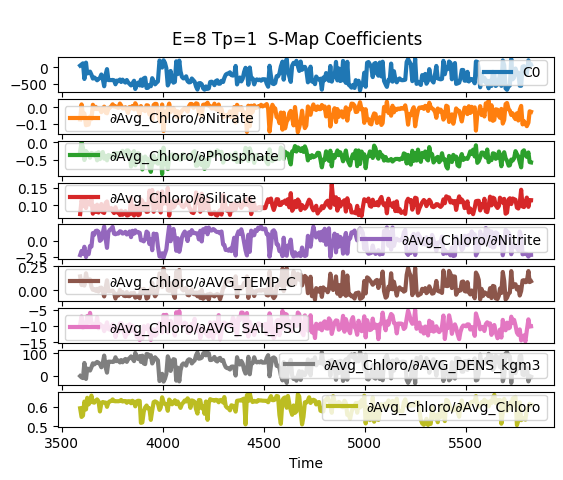

Theta: 1
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.039603960396039604, TP Rate: 0.25


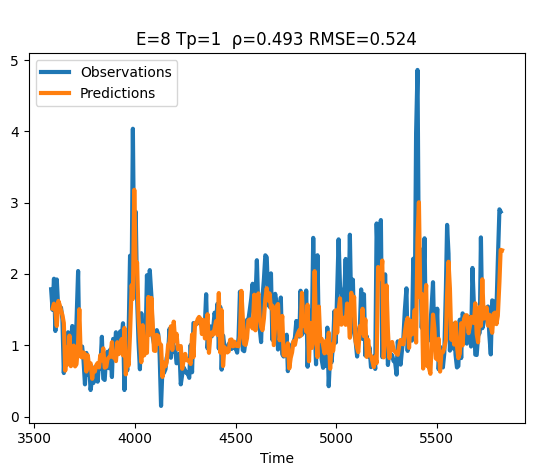

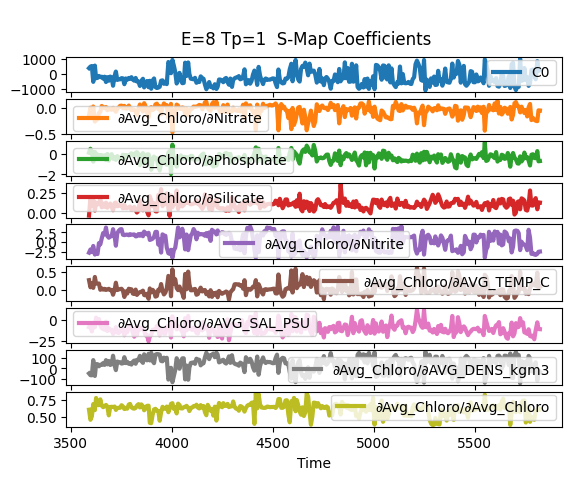

Theta: 2
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.033003300330033, TP Rate: 0.375


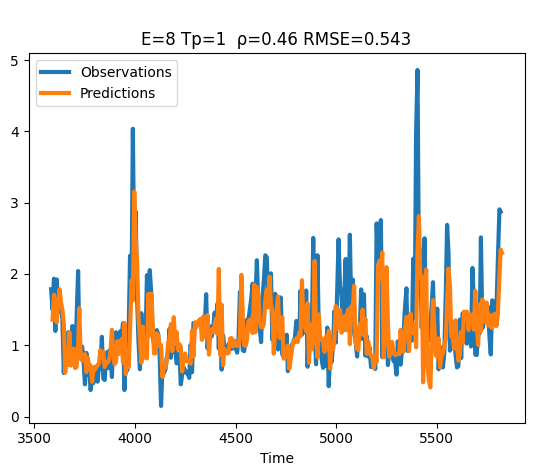

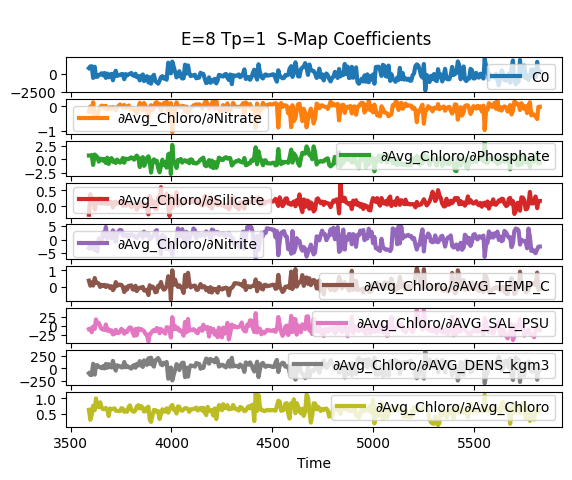

Theta: 3
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.039603960396039604, TP Rate: 0.25


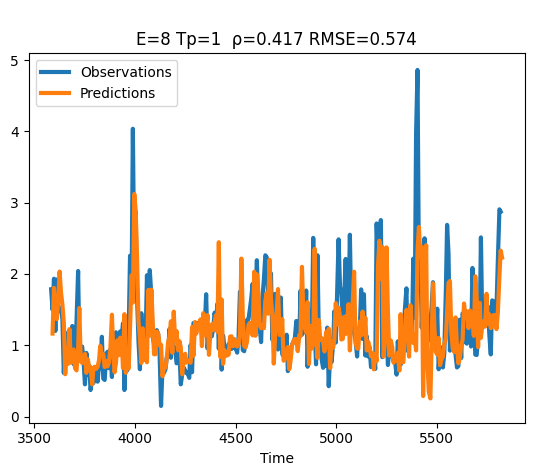

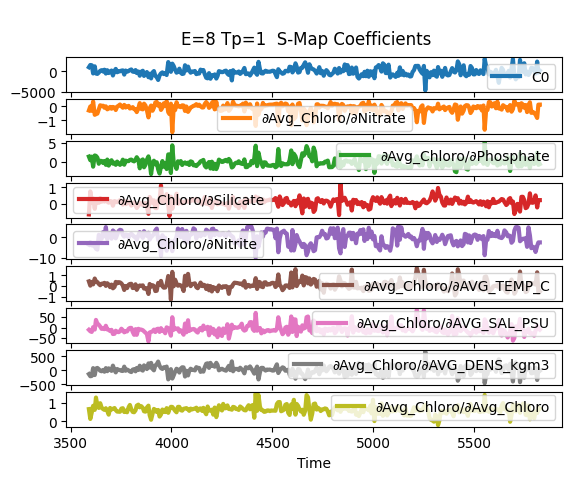

Theta: 4
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.036303630363036306, TP Rate: 0.3125


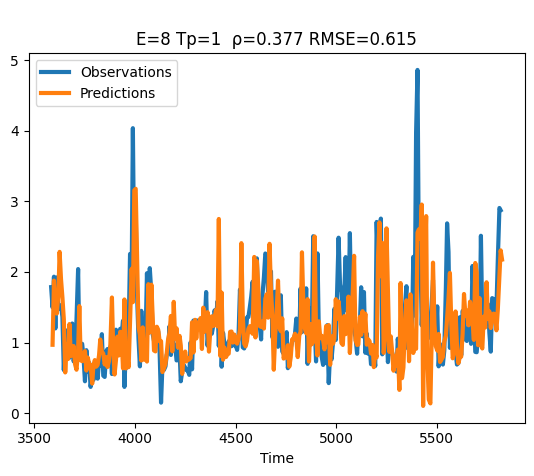

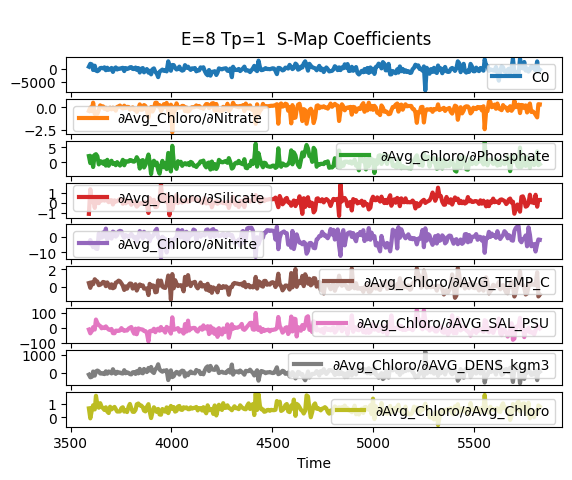

Theta: 5
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.036303630363036306, TP Rate: 0.3125


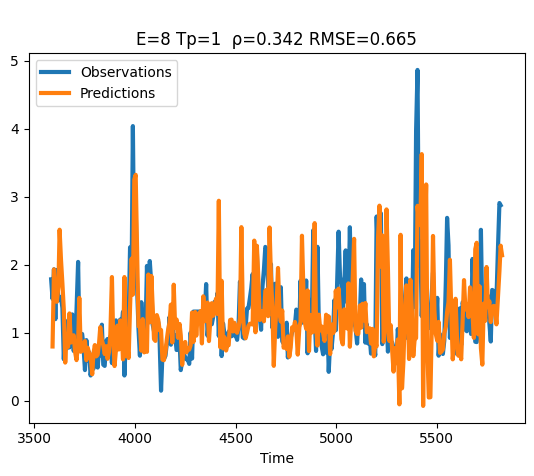

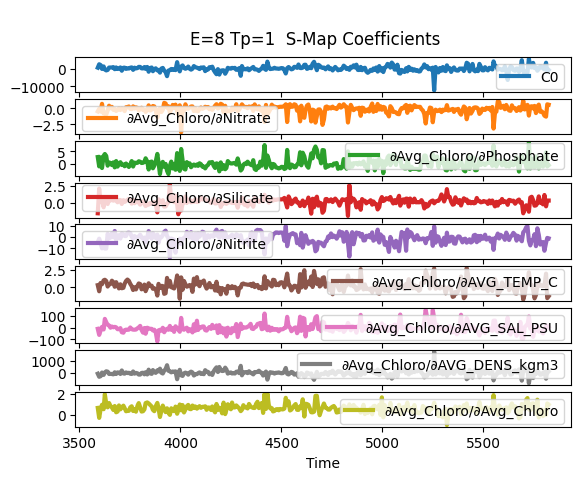

Theta: 6
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.039603960396039604, TP Rate: 0.25


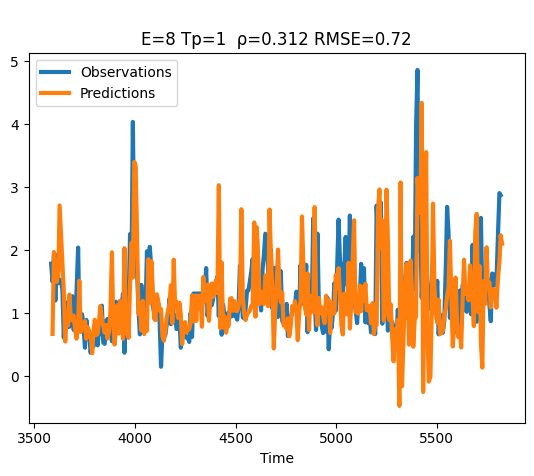

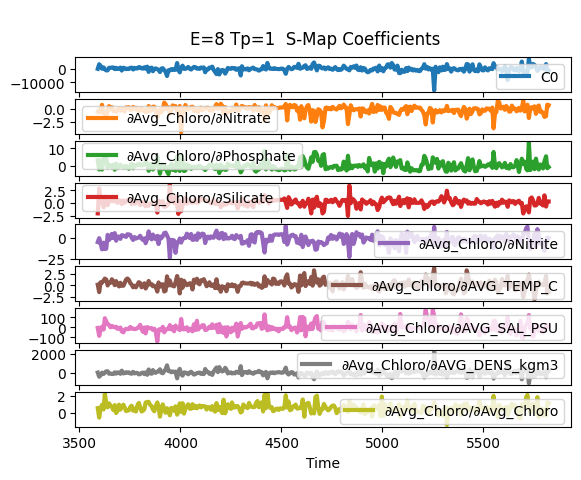

Theta: 7
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.0429042904290429, TP Rate: 0.1875


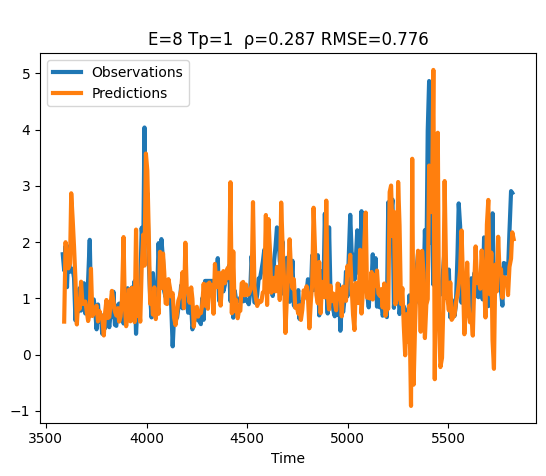

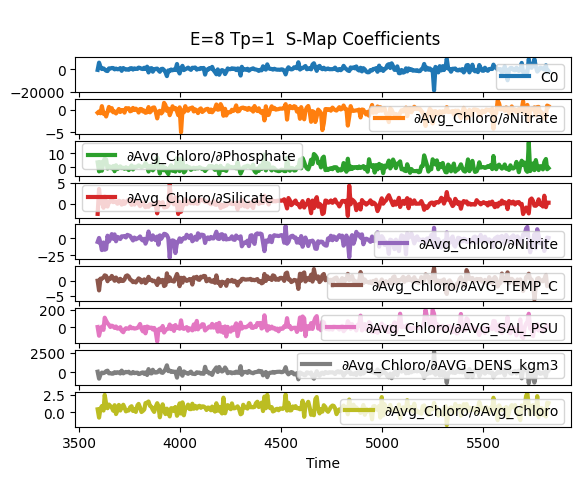

Theta: 8
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.0429042904290429, TP Rate: 0.1875


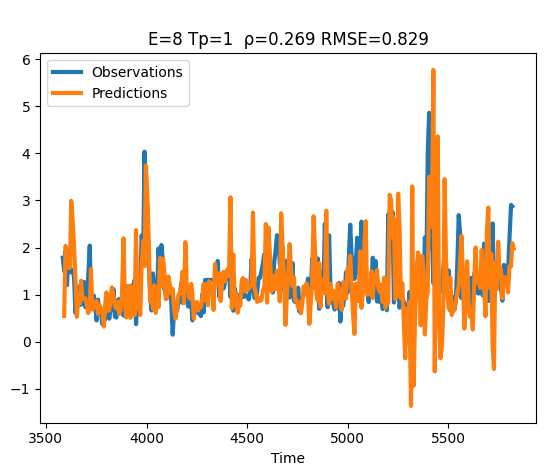

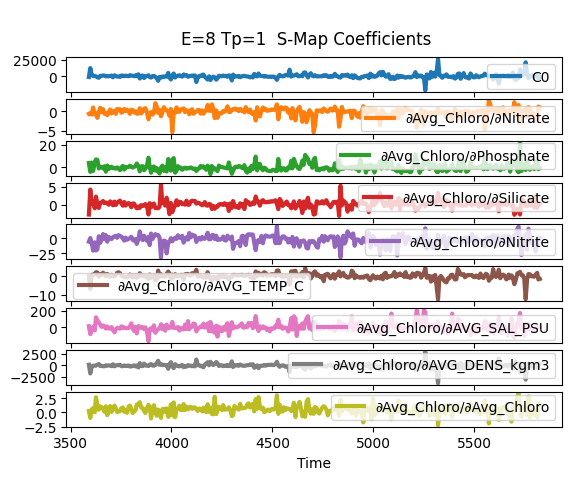

Theta: 9
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.0429042904290429, TP Rate: 0.1875


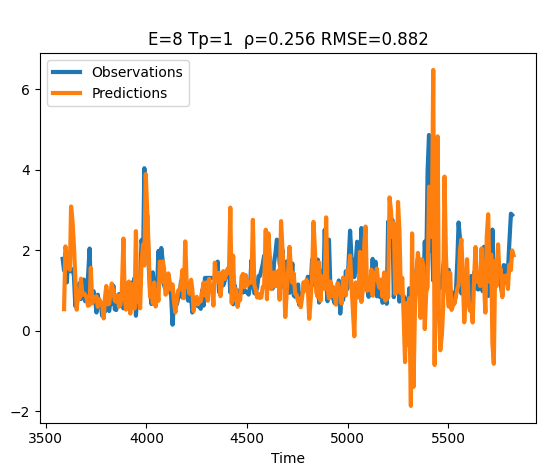

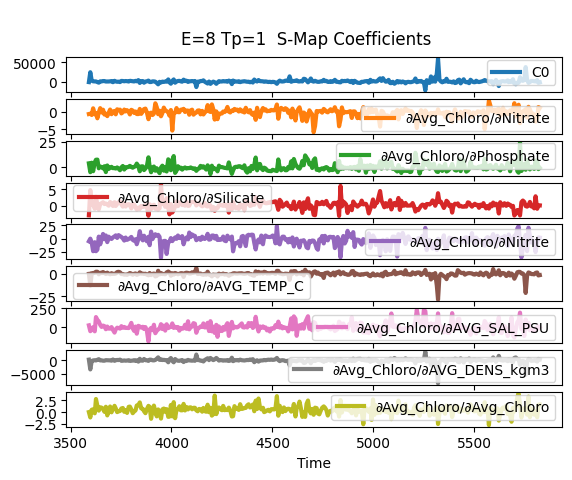

Theta: 10
Observations sample: [1.49738841 1.93296964 1.19996478 1.92278773 1.47476301]
Predictions sample: [0.53381727 2.09384207 1.81254899 1.57631133 1.51348537]
FP Rate: 0.039603960396039604, TP Rate: 0.25


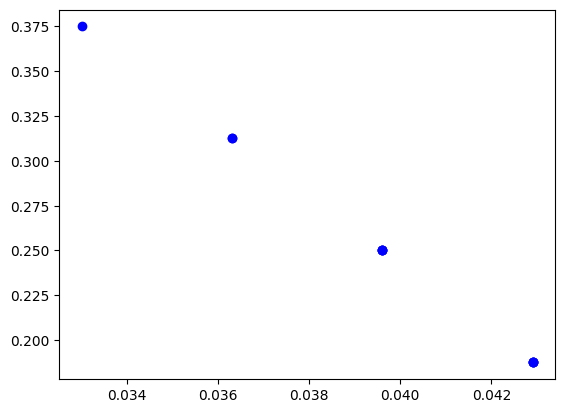

In [242]:
x, y = [], []
for i in range(0, 11):
    result = edm.SMap(
        dataFrame=time_series,
        columns=" ".join(features),
        target="Avg_Chloro",
        lib="1 512",
        pred="513 832",
        E=8,
        tau=-1,
        theta=i,
        showPlot=True,
        embedded=True,
        ignoreNan=True
    )

#     observations = result["predictions"]["Observations"].iloc[1:-1]
#     predictions = result["predictions"]["Predictions"].iloc[1:-1]
#     cur_bloom = bloom_binary_prediction(result['predictions']['Observations'].iloc[1:-1],result['predictions']['Predictions'].iloc[1:-1])
#     x.append(cur_bloom[2]) #False positive
#     y.append(cur_bloom[1]) #True positive
    print(f"Theta: {i}")
    print("Observations sample:", observations.head().values)
    print("Predictions sample:", predictions.head().values)
    cur_bloom = bloom_binary_prediction(
    result["predictions"]["Observations"].iloc[1:-1],
    result["predictions"]["Predictions"].iloc[1:-1], np.log(8.03199999999999)
    # result["predictions"]["Predictions"].iloc[1:-1], 8.03199999999999 #plot only has one point 0,0 ALL FP and TP rates are 0
    )

    x.append(cur_bloom[2])  # False positive rate
    y.append(cur_bloom[1])  # True positive rate
    print(f"FP Rate: {cur_bloom[2]}, TP Rate: {cur_bloom[1]}")
plt.scatter(x, y, color='blue', label='Data Points')

In [233]:
# print(result["predictions"].head())  
